In [1]:
import numpy as np
import torch
import cv2
import seaborn as sns

from models import model_dict
from helper.util_gen import get_sample_q

# Get model and replay buffer

In [2]:
!ls save/student_model/resnet26x10_cifar100_lr_1e-05_decay_0.0_buffer_size_10000_lpx_0.0_lpxy_1.0_energy_mode_mcmc_step_size_1.0_trial_3_py_cls_mode_cls

img_sample_eavl_grid  log.txt	      res_epoch_180.pts  res_epoch_210.pts
img_sample_eval       pxy_energy.npy  res_epoch_190.pts  res_epoch_220.pts
img_samples	      qxy_energy.npy  res_epoch_200.pts  res_epoch_230.pts


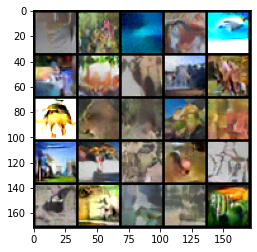

In [3]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
model = model_dict['resnet26x10'](num_classes=100)
model = model_dict['Score'](model, n_cls=100)
save_path = '/data/lijingru/EBKD/save/student_model/resnet26x10_cifar100_lr_1e-05_decay_0.0_buffer_size_10000_lpx_0.0_lpxy_1.0_energy_mode_mcmc_step_size_1.0_trial_3_py_cls_mode_cls/'
ckpt_dict = torch.load(save_path + 'res_epoch_230.pts')
model.load_state_dict(ckpt_dict["model_state_dict"])
replay_buffer = ckpt_dict["replay_buffer"]
sqrt = lambda x: int(torch.sqrt(torch.tensor([x])))
plot = lambda x: vutils.make_grid(torch.clamp(x, -1, 1), normalize=True, nrow=sqrt(x.size(0)))
buffer_size = len(replay_buffer)
inds = torch.randint(0, buffer_size, (25,))
sampled = replay_buffer[inds]
imgs = plot(sampled)
img = np.transpose(imgs, (1,2,0))
plt.figure(10)
plt.imshow(img)

### Calculate Inception Score and Options

In [4]:
import os
# save_path = '/data/lijingru/EBKD/save/student_model/resnet8x4_cifar100_lr_0.0001_decay_0.0_buffer_size_40000_lpx_0.0_lpxy_1.0_energy_mode_mcmc_step_size_5.0_trial_2_cls/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

class Options:
    def __init__(self, save_grid=False):
        self.n_cls = 100
        self.save_folder = save_path
        if not save_grid:
            self.save_dir = os.path.join(save_path, 'img_sample_eval/')
        else:
            self.save_dir = os.path.join(save_path, 'img_sample_eavl_grid/')
        self.save_grid = save_grid
        self.reinit_freq = 0.05
        self.batch_size = 1
        self.step_size = 2
        self.dataset = 'cifar100'
        self.g_steps = 25
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

        
opt = Options()

## Visualize sample q
The visualization of $x \sim q_{\theta}$.

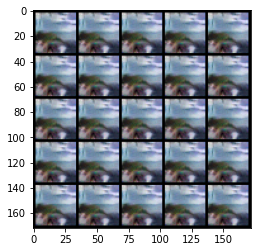

In [5]:
from helper.util_gen import get_sample_q
model.cuda()
sample_q, _ = get_sample_q(opt)
f_sample, samples = sample_q(model, replay_buffer, open_debug=True)
samples = torch.cat(samples, 0).cpu()
imgs = plot(samples)
img = np.transpose(imgs, (1,2,0))
plt.figure(10)
plt.imshow(img)

In [6]:
from helper.util_gen import cond_samples
opt = Options()
if not os.path.exists(opt.save_dir):
    os.mkdir(opt.save_dir)
# model.cuda()
cond_samples(model, replay_buffer, opt)

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]

Successfully saving the generated result of replay buffer.


In [7]:
from helper.util import inception_score
from datasets.cifar100 import CIFAR100Gen
import torchvision.transforms as T
if not opt.save_grid:
    test_folder = opt.save_dir
    dataset = CIFAR100Gen(
        root=test_folder,
        transform=T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    )
    mean, var = inception_score(dataset, resize=True, splits=10, batch_size=8)
    print(mean, var)

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


4.684983736681977 0.1661676431427952


In [8]:
optd = Options(save_grid=True)
cond_samples(model, replay_buffer, optd)

100%|██████████| 100/100 [00:02<00:00, 33.70it/s]

Successfully saving the generated result of replay buffer.


### t-SNE visualization

## Set options, datasets and dataloaders

In [9]:
from datasets.cifar100 import CIFAR100Gen, CIFAR100Instance
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image

test_folder = '/data/lijingru/cifar100/'
test_gen_folder = '/data/lijingru/img_sample_eval/'


test_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]


# train_transform = transforms.Compose(train_list)
test_transform = transforms.Compose(test_list)
test_positive_set = CIFAR100Instance(root=test_folder, download=True, train=False, transform=test_transform)
test_negative_set = CIFAR100Gen(root=opt.save_dir, transform=test_transform, return_target=True)

test_p_loader = DataLoader(dataset=test_positive_set, batch_size=1, shuffle=False, num_workers=8)
test_n_loader = DataLoader(dataset=test_negative_set, batch_size=1, shuffle=False, num_workers=8)

Files already downloaded and verified


In [10]:
import tqdm
model.eval()
p_energys = []
q_energys = []
correct = 0
p_predict = []
for idx, data in tqdm.tqdm(enumerate(test_p_loader)):
    x, y, i = data
    x = x.cuda()
    y = y.cuda()
    logit = model(x=x, cls_mode=True)
    indexs = torch.argmax(logit, 1)
    p_predict += indexs.tolist()
    b_correct = torch.sum(indexs == y).item()
    correct += b_correct
    f = torch.gather(logit, 1, y[:, None]).mean()
    
    f = model(x=x, y=y)[0].mean()
    p_energys.append(f.item())
    
print('Positive Samples:')
print('Max: {:.4f}'.format(max(p_energys)))
print('Min: {:.4f}'.format(min(p_energys)))
print('Mean: {:.4f}'.format(sum(p_energys) / len(p_energys)))
print('Acc: {:.4f}'.format(correct / len(test_p_loader)))

for idx, data in tqdm.tqdm(enumerate(test_n_loader)):
    x, y, i = data
    x = x.cuda()
    y = y.cuda()
    
    f = model(x=x, y=y)[0].mean()
    q_energys.append(f.item())
    


print('Negative Samples:')
print('Max: {:.4f}'.format(max(q_energys)))
print('Min: {:.4f}'.format(min(q_energys)))
print('Mean: {:.4f}'.format(sum(q_energys) / len(q_energys)))

10000it [02:00, 83.06it/s]

Positive Samples:
Max: 22.0380
Min: -39.6917
Mean: -1.8404
Acc: 0.4130



10000it [01:06, 149.69it/s]

Negative Samples:
Max: 20.1425
Min: -50.5806
Mean: -0.4861


In [11]:
np.save(os.path.join(opt.save_folder, 'pxy_energy.npy'), np.asarray(p_energys))
np.save(os.path.join(opt.save_folder, 'qxy_energy.npy'), np.asarray(q_energys))

## Plot the distribution of energy function
$x^+ \sim p_{data}$, and $x^- \sim q_{\theta}$. If the EBM is well-trained, the plotted distribution should be close enough.

Here presented the distribution of conditional generation $p_{\theta}(x | y)$.

<AxesSubplot:ylabel='Density'>

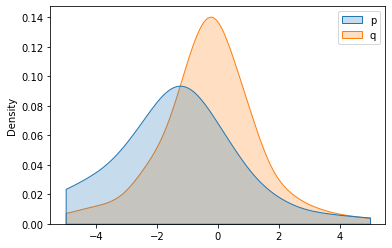

In [12]:
sns.kdeplot(data={'p':p_energys, 'q':q_energys}, clip=(-5, 5), fill=True)

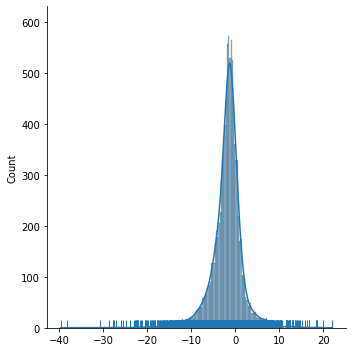

In [13]:
sns.displot(x=p_energys, kde=True, rug=True)

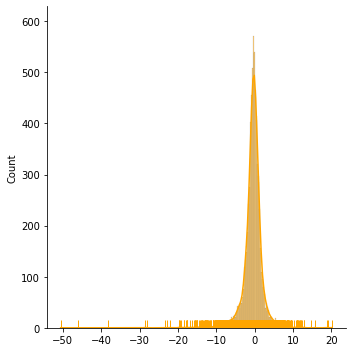

In [14]:
sns.displot(x=q_energys, color='orange', rug=True, kde=True)

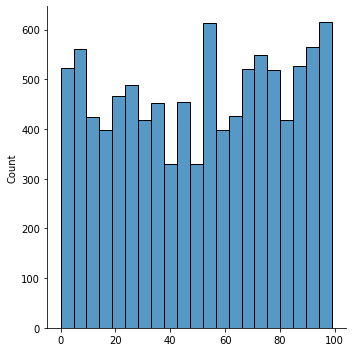

In [15]:
sns.displot(x=p_predict)

## Unconditional energy distribution
Considering the distribution of unconditional generation $p_{\theta}(x)$.

In [16]:
model.eval()
p_energys = []
q_energys = []
for idx, data in tqdm.tqdm(enumerate(test_p_loader)):
    x, y, i = data
    x = x.cuda()
    y = y.cuda()
    
    f = model(x=x)[0].mean()
    p_energys.append(f.item())
    
print('Positive Samples:')
print('Max: {:.4f}'.format(max(p_energys)))
print('Min: {:.4f}'.format(min(p_energys)))
print('Mean: {:.4f}'.format(sum(p_energys) / len(p_energys)))

for idx, data in tqdm.tqdm(enumerate(test_n_loader)):
    x, y, i = data
    x = x.cuda()
    y = y.cuda()
    
    f = model(x=x)[0].mean()
    q_energys.append(f.item())
    


print('Negative Samples:')
print('Max: {:.4f}'.format(max(q_energys)))
print('Min: {:.4f}'.format(min(q_energys)))
print('Mean: {:.4f}'.format(sum(q_energys) / len(q_energys)))

10000it [02:05, 79.92it/s]

Positive Samples:
Max: 22.0380
Min: -15.3137
Mean: 0.6616



10000it [02:06, 79.23it/s]

Negative Samples:
Max: 20.1425
Min: -15.5259
Mean: 0.6895


In [20]:
np.save(os.path.join(opt.save_folder, 'px_energy.npy'), np.asarray(p_energys))
np.save(os.path.join(opt.save_folder, 'qx_energy.npy'), np.asarray(q_energys))

<AxesSubplot:ylabel='Density'>

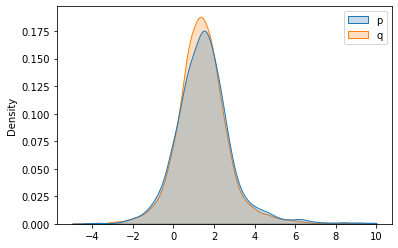

In [21]:
sns.kdeplot(data={'p':p_energys, 'q':q_energys}, clip=(-5, 10), fill=True)

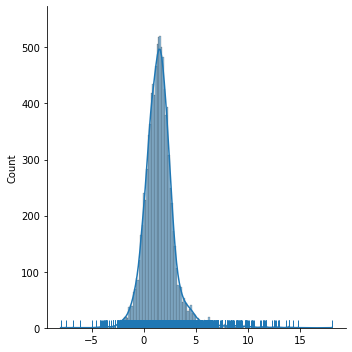

In [22]:
sns.displot(x=p_energys, kde=True, rug=True)

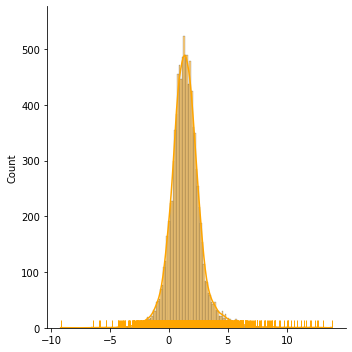

In [23]:
sns.displot(x=q_energys, color='orange', rug=True, kde=True)